In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
import sys, os

sys.path.append(os.path.abspath("../"))

In [24]:
from src.models.iv import HestonSmallTimeIV
from src.utls.dataprocess import datatype_trans
from scipy.optimize import least_squares
stmodel = HestonSmallTimeIV((-0.4, 0.1, 0.5), None, None)

## Data Pre Process

In [4]:
data = pd.read_csv('../data/eth_options_iv.csv')
data = datatype_trans(data, time_list=["hr_time", "expired_date"], data_list=["strikes", "call_ivs", "put_ivs", "otm_ivs", "call_amounts", "put_amounts"])

data['TtE'] = data['expired_date'] - data['hr_time'] 

data.head()

,hr_time,expired_date,spot,strikes,call_ivs,put_ivs,call_amounts,put_amounts,expiry,mark_call_prices,mark_put_prices,otm_ivs,otm_amounts,TtE
0,2023-09-16 01:00:00+00:00,2023-10-27 08:00:00+00:00,1642.50,"[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600...","[0, 72.18, 64.33, 56.97, 49.42, 42.14, 35.3, 3...","[79.64, 72.18, 64.33, 56.97, 49.42, 42.14, 35....","[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 169.0, 496.0...","[71.0, 114.0, 48.0, 1.0, 828.0, 422.0, 80.0, 6...",1698393600,"[0, 646.4328959999999, 547.72706, 450.00664, 3...","[1.314416, 2.299864, 3.613192, 5.5840239999999...","[79.64, 72.18, 64.33, 56.97, 49.42, 42.14, 35....","[71.0, 114.0, 48.0, 1.0, 828.0, 422.0, 80.0, 6...",41 days 07:00:00
1,2023-09-16 02:00:00+00:00,2023-10-27 08:00:00+00:00,1643.92,"[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600...","[0, 71.76, 64.33, 57.03, 48.81, 42.12, 35.21, ...","[78.51, 71.76, 64.33, 57.03, 48.81, 42.12, 35....","[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 169.0, 316.0...","[43.0, 156.0, 46.0, 1.0, 337.0, 412.0, 248.0, ...",1698393600,"[0, 647.1079119999999, 548.7980399999999, 451....","[1.150219, 2.136173, 3.4508039999999998, 5.587...","[78.51, 71.76, 64.33, 57.03, 48.81, 42.12, 35....","[43.0, 156.0, 46.0, 1.0, 337.0, 412.0, 248.0, ...",41 days 06:00:00
2,2023-09-16 03:00:00+00:00,2023-10-27 08:00:00+00:00,1647.08,"[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600...","[0, 71.91, 64.64, 57.53, 49.21, 42.09, 35.46, ...","[78.94, 71.9, 64.64, 57.53, 49.21, 42.11, 35.4...","[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 168.0, 854.0...","[43.0, 40.0, 48.0, 2.0, 368.0, 387.0, 205.0, 8...",1698393600,"[0, 650.945776, 552.447402, 454.79192, 357.440...","[1.152984, 2.141542, 3.4589519999999996, 5.600...","[78.94, 71.9, 64.64, 57.53, 49.21, 42.11, 35.4...","[43.0, 40.0, 48.0, 2.0, 368.0, 387.0, 205.0, 8...",41 days 05:00:00
3,2023-09-16 04:00:00+00:00,2023-10-27 08:00:00+00:00,1642.34,"[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600...","[0, 72.0, 64.49, 57.15, 48.86, 41.65, 35.09, 3...","[78.67, 72.0, 64.49, 57.15, 48.86, 41.65, 35.0...","[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 169.0, 235.0...","[43.0, 40.0, 48.0, 2.0, 1.0, 528.0, 254.0, 97....",1698393600,"[0, 646.130935, 547.6103350000001, 449.9107400...","[1.149372, 2.298744, 3.612422, 5.5826639999999...","[78.67, 72.0, 64.49, 57.15, 48.86, 41.65, 35.0...","[43.0, 40.0, 48.0, 2.0, 1.0, 528.0, 254.0, 97....",41 days 04:00:00
4,2023-09-16 05:00:00+00:00,2023-10-27 08:00:00+00:00,1639.75,"[900, 1000, 1100, 1200, 1300, 1400, 1500, 1600...","[0, 71.78, 64.35, 57.02, 48.65, 41.82, 35.05, ...","[78.57, 71.82, 64.35, 57.01, 48.66, 41.82, 35....","[0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 170.0, 235.0...","[43.0, 40.0, 48.0, 2.0, 1.0, 547.0, 277.0, 117...",1698393600,"[0, 644.2391359999999, 545.8319359999999, 448....","[1.1480629999999998, 2.1321169999999996, 3.608...","[78.57, 71.82, 64.35, 57.01, 48.66, 41.82, 35....","[43.0, 40.0, 48.0, 2.0, 1.0, 547.0, 277.0, 117...",41 days 03:00:00


### Calibration Models

In [121]:
def residuals(params, x, market_iv):
    rho, sigma, y0 = params
    model_iv = stmodel.IV_curve([rho, sigma, y0], x)
    return model_iv - market_iv

def calibrate_iv_smile(K, S0, market_iv, initial_guess=(0.0, 50000, 40)):
    x = np.log(K / S0)
    market_iv = np.array(market_iv)
    res = least_squares(residuals, initial_guess, bounds=([-0.999, 50000, 10], [0.999, 100000, 50]), args=(x, market_iv))
    rho, sigma, y0 = res.x
    return rho, sigma, y0, res

def residuals_with_weight(params, x, market_iv, amounts):
    rho, sigma, y0 = params
    model_iv = stmodel.IV_curve([rho, sigma, y0], x)
    return (model_iv - market_iv)*amounts

def weighted_calibrate_iv_smile(K, S0, market_iv, amounts, initial_guess=(0.0, 50000, 40)):
    x = np.log(K / S0)
    market_iv = np.array(market_iv)
    res = least_squares(
        lambda params: residuals_with_weight(params, x, market_iv, amounts), 
        initial_guess, 
        bounds=([-0.6, 10000, 10], [0.6, 200000, 40]))
    rho, sigma, y0 = res.x
    return rho, sigma, y0, res

In [122]:
data_short = data[data['TtE'] == pd.Timedelta(hours=2)].reset_index()
data_short_future = data[data['TtE'] == pd.Timedelta(hours=1)].reset_index()

results = []
for i in range(data_short.shape[0]):
    K = data_short['strikes'][i]
    S0 = data_short['spot'][i]
    otm_iv=  data_short['put_ivs'][i]

    call_out_filter = K > S0
    put_out_filter = K <= S0
    otm_amount = np.zeros(len(K))

    call_amount = np.array(data_short["call_amounts"][i])
    put_amount = np.array(data_short["put_amounts"][i])

    otm_amount[call_out_filter] = call_amount[call_out_filter]
    otm_amount[put_out_filter] = put_amount[put_out_filter]

    # min-max normalization
    otm_amount = [(otm_amount[j]-otm_amount.min())/(otm_amount.max()-otm_amount.min()) for j in range(len(otm_amount))]
    
    # calibration
    rho, sigma, y0, res = calibrate_iv_smile(K, S0, otm_iv)
    rho_w, sigma_w, y0_w, res_w = weighted_calibrate_iv_smile(K, S0, otm_iv, otm_amount)

    # future price
    current_time = data_short['hr_time'][i]
    future_time  = current_time + timedelta(hours=1)
    
    future_data = data_short_future[data_short_future["hr_time"] == future_time]
    future_price = future_data['spot']
    
    results.append({
        "rho": rho,
        "sigma": sigma,
        "y0": y0,
        "rho_w": rho_w,
        "sigma_w": sigma_w,
        "y0_w": y0_w,
        "trend": int(future_price.iloc[0]>S0)
    })

In [123]:
df = pd.DataFrame(results)
df

,rho,sigma,y0,rho_w,sigma_w,y0_w,trend
0,0.017039,100000.000000,50.000000,-0.600000,83831.024870,40.0,1
1,-0.511577,100000.000000,50.000000,-0.600000,200000.000000,40.0,0
2,-0.366713,100000.000000,50.000000,-0.600000,142430.831473,40.0,0
3,-0.307717,99999.995481,49.999999,-0.600000,200000.000000,40.0,1
4,-0.783183,100000.000000,50.000000,-0.600000,200000.000000,40.0,0
5,-0.604418,99994.470116,49.999972,-0.600000,200000.000000,40.0,0
6,-0.649140,99999.999994,50.000000,-0.600000,200000.000000,40.0,1
7,-0.423644,99987.562064,49.999900,-0.600000,200000.000000,40.0,0
8,-0.303166,100000.000000,50.000000,-0.600000,170463.506972,40.0,0
9,-0.998646,100000.000000,50.000000,-0.600000,200000.000000,40.0,1


R2 Score: 0.012103146874824056


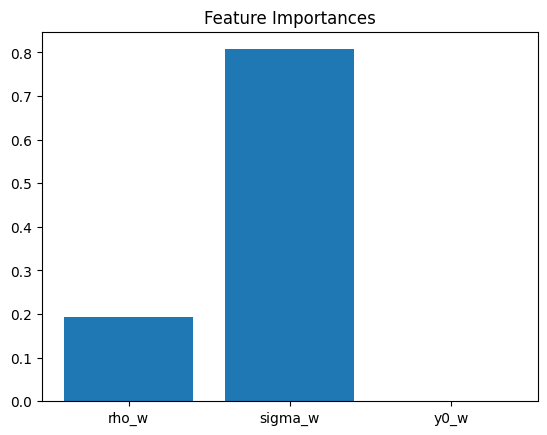

In [130]:

# Feature columns (Heston params + anything else)
features = ["rho_w", "sigma_w", "y0_w"]  # Add more if available
X = df[features]
y = df["trend"]

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # shuffle=False keeps time order

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

# Feature importance
importances = model.feature_importances_
plt.bar(features, importances)
plt.title("Feature Importances")
plt.show()
